# Analyzing hurricane tracks - Part 3/3
This is the third part to a three part set of notebooks that process and analyze historic hurricane tracks. In the previous notebooks we saw

**Part 1**
 1. downloading historic hurricane datasets using Python
 2. cleaning and merging hurricane observations using DASK
 3. aggregating point observations into hurricane tracks using ArcGIS GeoAnalytics server

**Part 2**
 1. Visualize the locations of hurricane tracks
 2. Different basins and the number of hurricanes per basin
 3. Number of hurricanes over time
 4. Seasonality in occurrence of hurricanes
 5. Places where hurricanes make landfall and the people affected

In this notebook you will analyze the aggregated tracks to answer important questions about hurricane severity and how they correlate over time.

<h1>**Table of Contents**<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyzing-hurricane-tracks---Part-3/3" data-toc-modified-id="Analyzing-hurricane-tracks---Part-3/3-1">Analyzing hurricane tracks - Part 3/3</a></span><ul class="toc-item"><li><span><a href="#Access-aggregated-hurricane-data" data-toc-modified-id="Access-aggregated-hurricane-data-1.1">Access aggregated hurricane data</a></span><ul class="toc-item"><li><span><a href="#Query-hurricane-tracks-into-a-Spatially-enabled-DataFrame" data-toc-modified-id="Query-hurricane-tracks-into-a-Spatially-enabled-DataFrame-1.1.1">Query hurricane tracks into a Spatially enabled <code>DataFrame</code></a></span></li><li><span><a href="#Query-landfall-tracks-layer-into-a-Spatially-Enabled-DataFrame" data-toc-modified-id="Query-landfall-tracks-layer-into-a-Spatially-Enabled-DataFrame-1.1.2">Query landfall tracks layer into a Spatially Enabled <code>DataFrame</code></a></span></li></ul></li><li><span><a href="#Manage-missing-sesnsor-data" data-toc-modified-id="Manage-missing-sesnsor-data-1.2">Manage missing sesnsor data</a></span><ul class="toc-item"><li><span><a href="#Visualize-missing-records" data-toc-modified-id="Visualize-missing-records-1.2.1">Visualize missing records</a></span></li><li><span><a href="#Missing-value-imputation" data-toc-modified-id="Missing-value-imputation-1.2.2">Missing value imputation</a></span></li></ul></li></ul></li><li><span><a href="#Does-intensity-of-hurricanes-increase-over-time?" data-toc-modified-id="Does-intensity-of-hurricanes-increase-over-time?-2">Does intensity of hurricanes increase over time?</a></span><ul class="toc-item"><li><span><a href="#Does-the-number-of-hurricanes-increase-over-time?" data-toc-modified-id="Does-the-number-of-hurricanes-increase-over-time?-2.1">Does the number of hurricanes increase over time?</a></span></li><li><span><a href="#Does-hurricane-wind-speed-increase-over-time?" data-toc-modified-id="Does-hurricane-wind-speed-increase-over-time?-2.2">Does hurricane wind speed increase over time?</a></span><ul class="toc-item"><li><span><a href="#Analyzing-hurricane-wind-speed-over-time-by-basin" data-toc-modified-id="Analyzing-hurricane-wind-speed-over-time-by-basin-2.2.1">Analyzing hurricane wind speed over time by basin</a></span></li><li><span><a href="#Analyzing-hurricane-category-over-time-by-basin" data-toc-modified-id="Analyzing-hurricane-category-over-time-by-basin-2.2.2">Analyzing hurricane category over time by basin</a></span></li></ul></li><li><span><a href="#Does-eye-pressure-decrease-over-time?" data-toc-modified-id="Does-eye-pressure-decrease-over-time?-2.3">Does eye pressure decrease over time?</a></span></li><li><span><a href="#Do-hurricanes-linger-longer-over-time?" data-toc-modified-id="Do-hurricanes-linger-longer-over-time?-2.4">Do hurricanes linger longer over time?</a></span></li><li><span><a href="#Do-hurricanes-travel-longer-inland-over-time?" data-toc-modified-id="Do-hurricanes-travel-longer-inland-over-time?-2.5">Do hurricanes travel longer inland over time?</a></span></li><li><span><a href="#Correlate-observations-over-time" data-toc-modified-id="Correlate-observations-over-time-2.6">Correlate observations over time</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.7">Conclusion</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#References" data-toc-modified-id="References-2.7.0.1">References</a></span></li></ul></li></ul></li></ul></li></ul></div>

Import the libraries necessary for this notebook.

In [1]:
# import ArcGIS Libraries
from arcgis.gis import GIS
from arcgis.geometry import filters
from arcgis.geocoding import geocode
from arcgis.features.manage_data import overlay_layers
from arcgis.geoenrichment import enrich

# import Pandas for data exploration
import pandas as pd
import numpy as np
from scipy import stats

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import display tools
from pprint import pprint
from IPython.display import display

# import system libs
from sys import getsizeof

In [3]:
gis = GIS('home')

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Access aggregated hurricane data
Below, we access the tracks aggregated using GeoAnalytics in the previous notebook.

In [4]:
hurricane_tracks_item = gis.content.search('title:hurricane_tracks_aggregated_ga')[0]
hurricane_fl = hurricane_tracks_item.layers[0]

The **GeoAnalytics** step calculated summary statistics of all numeric fields. However only a few of the columns are of interest to us.

In [5]:
pprint([f['name'] for f in hurricane_fl.properties.fields], compact=True, width=80)

['objectid', 'serial_num', 'count', 'count_col_1', 'sum_col_1', 'min_col_1',
 'max_col_1', 'mean_col_1', 'range_col_1', 'sd_col_1', 'var_col_1',
 'count_season', 'sum_season', 'min_season', 'max_season', 'mean_season',
 'range_season', 'sd_season', 'var_season', 'count_num', 'sum_num', 'min_num',
 'max_num', 'mean_num', 'range_num', 'sd_num', 'var_num', 'count_basin',
 'any_basin', 'count_sub_basin', 'any_sub_basin', 'count_name', 'any_name',
 'count_iso_time', 'any_iso_time', 'count_nature', 'any_nature', 'count_center',
 'any_center', 'count_track_type', 'any_track_type', 'count_current_basin',
 'any_current_basin', 'count_latitude_merged', 'sum_latitude_merged',
 'min_latitude_merged', 'max_latitude_merged', 'mean_latitude_merged',
 'range_latitude_merged', 'sd_latitude_merged', 'var_latitude_merged',
 'count_longitude_merged', 'sum_longitude_merged', 'min_longitude_merged',
 'max_longitude_merged', 'mean_longitude_merged', 'range_longitude_merged',
 'sd_longitude_merged', 'var_long

Below we select the following fields for the rest of this analysis.

In [9]:
fields_to_query = ['objectid', 'count', 'min_season', 'any_basin', 'any_sub_basin',
                   'any_name', 'mean_latitude_merged', 'mean_longitude_merged',
                   'max_wind_merged', 'range_wind_merged', 'min_pressure_merged',
                   'range_pressure_merged', 'max_eye_dia_merged', 'track_duration',
                   'end_datetime', 'start_datetime']

### Query hurricane tracks into a Spatially enabled `DataFrame`

In [10]:
%%time
all_hurricanes_df = hurricane_fl.query(out_fields=','.join(fields_to_query), as_df=True)

CPU times: user 1.12 s, sys: 318 ms, total: 1.43 s
Wall time: 4.5 s


In [11]:
all_hurricanes_df.shape

(12362, 17)

There are **`12,362`** hurricanes identified by GeoAnalytics aggregate tracks tool. To get an idea about this aggregated dataset, call the `head()` method.

In [12]:
all_hurricanes_df.head()

,SHAPE,any_basin,any_name,any_sub_basin,count,end_datetime,max_eye_dia_merged,max_wind_merged,mean_latitude_merged,mean_longitude_merged,min_pressure_merged,min_season,objectid,range_pressure_merged,range_wind_merged,start_datetime,track_duration
0,"{""paths"": [[[59.60000000000002, -17.6000000000...",SI,NOT NAMED,MM,7.0,1854-02-10 18:00:00,NaN,NaN,-19.318571,60.639286,NaN,1854.0,1,NaN,NaN,1854-02-08 06:00:00,1.296000e+08
1,"{""paths"": [[[-23.5, 12.5], [-24.19999999999999...",NA,NOT NAMED,NA,9.0,1859-08-26 12:00:00,NaN,45.0,14.000000,-26.222222,NaN,1859.0,2,NaN,10.0,1859-08-24 12:00:00,1.728000e+08
2,"{""paths"": [[[-23.19999999999999, 12.1000000000...",NA,UNNAMED,NA,50.0,1853-09-12 18:00:00,NaN,130.0,26.982000,-51.776000,924.0,1853.0,3,53.0,90.0,1853-08-30 00:00:00,1.058400e+09
3,"{""paths"": [[[59.80000000000001, -15.5], [59.49...",SI,XXXX856017,MM,13.0,1856-04-05 18:00:00,NaN,NaN,-20.185385,59.573077,NaN,1856.0,4,NaN,NaN,1856-04-02 18:00:00,2.592000e+08
4,"{""paths"": [[[99.60000000000002, -11.5], [98.30...",SI,NOT NAMED,WA,13.0,1861-03-15 18:00:00,NaN,NaN,-12.940769,94.183846,NaN,1861.0,5,NaN,NaN,1861-03-12 18:00:00,2.592000e+08


To better analyze this data set, the date columns need to be changed to a format that Pandas understands better. This is accomplished by calling `to_datetime()` method and passing the appropriate time columns.

In [14]:
all_hurricanes_df['start_datetime'] = pd.to_datetime(all_hurricanes_df['start_datetime'])
all_hurricanes_df['end_datetime'] = pd.to_datetime(all_hurricanes_df['end_datetime'])
all_hurricanes_df.index = all_hurricanes_df['start_datetime']
all_hurricanes_df.head()

,SHAPE,any_basin,any_name,any_sub_basin,count,end_datetime,max_eye_dia_merged,max_wind_merged,mean_latitude_merged,mean_longitude_merged,min_pressure_merged,min_season,objectid,range_pressure_merged,range_wind_merged,start_datetime,track_duration
start_datetime,,,,,,,,,,,,,,,,,
1854-02-08 06:00:00,"{""paths"": [[[59.60000000000002, -17.6000000000...",SI,NOT NAMED,MM,7.0,1854-02-10 18:00:00,NaN,NaN,-19.318571,60.639286,NaN,1854.0,1,NaN,NaN,1854-02-08 06:00:00,1.296000e+08
1859-08-24 12:00:00,"{""paths"": [[[-23.5, 12.5], [-24.19999999999999...",NA,NOT NAMED,NA,9.0,1859-08-26 12:00:00,NaN,45.0,14.000000,-26.222222,NaN,1859.0,2,NaN,10.0,1859-08-24 12:00:00,1.728000e+08
1853-08-30 00:00:00,"{""paths"": [[[-23.19999999999999, 12.1000000000...",NA,UNNAMED,NA,50.0,1853-09-12 18:00:00,NaN,130.0,26.982000,-51.776000,924.0,1853.0,3,53.0,90.0,1853-08-30 00:00:00,1.058400e+09
1856-04-02 18:00:00,"{""paths"": [[[59.80000000000001, -15.5], [59.49...",SI,XXXX856017,MM,13.0,1856-04-05 18:00:00,NaN,NaN,-20.185385,59.573077,NaN,1856.0,4,NaN,NaN,1856-04-02 18:00:00,2.592000e+08
1861-03-12 18:00:00,"{""paths"": [[[99.60000000000002, -11.5], [98.30...",SI,NOT NAMED,WA,13.0,1861-03-15 18:00:00,NaN,NaN,-12.940769,94.183846,NaN,1861.0,5,NaN,NaN,1861-03-12 18:00:00,2.592000e+08


The track duration and length columns need to be projected to units (days, hours, miles) that are meaningful for analysis.

In [15]:
all_hurricanes_df['track_duration_hrs'] = all_hurricanes_df['track_duration'] / 3600000
all_hurricanes_df['track_duration_days'] = all_hurricanes_df['track_duration'] / (3600000*24)

### Query landfall tracks layer into a Spatially Enabled `DataFrame`
We query the landfall tracks layer created in the pervious notebook into a DataFrame.

In [27]:
inland_tracks = gis.content.search('hurricane_landfall_tracks')[0]

fields_to_query = ['min_season', 'any_basin','any_name', 'max_wind_merged', 
                   'min_pressure_merged', 'track_duration','end_datetime', 
                   'start_datetime', 'analysislength']

landfall_tracks_fl = inland_tracks.layers[0]

In [28]:
landfall_tracks_df = landfall_tracks_fl.query(out_fields=fields_to_query).df
landfall_tracks_df.head(3)

,analysislength,any_basin,any_name,end_datetime,max_wind_merged,min_pressure_merged,min_season,objectid,start_datetime,track_duration,SHAPE
0,4.376642,NA,NOT NAMED,-3663424800000,95.0,965.0,1853.0,1,-3664699200000,1.317600e+09,"{'paths': [[[-74.47272727299998, 24], [-74.463..."
1,117.097286,NA,UNNAMED,-3645172800000,70.0,NaN,1854.0,2,-3645475200000,2.160000e+08,"{'paths': [[[-99.13749999999999, 26.5699999999..."
2,256.909588,NA,UNNAMED,-3645172800000,70.0,NaN,1854.0,3,-3645475200000,2.160000e+08,"{'paths': [[[-102.21739130399999, 27.686956522..."


## Manage missing sesnsor data
Before we can analyze if hurricanes intensify over time, we need to identify and account for missing values in our data. Sensor measurements such as **wind speed**, **atmospheric pressure**, **eye diameter**, generally suffer from missing values and outliers. The reconstruct tracks tool has identified `12,362` individual hurricanes that occurred during the past `169` years.

In [122]:
all_hurricanes_df.shape

(12362, 19)

### Visualize missing records
An easy way to visualize missing records is to hack the `heatmap` of `seaborn` library to display missing records. The snippet below shows missing records in **yellow** color.

Text(0.5,1,'Missing values (yellow) visualized as a heatmap')

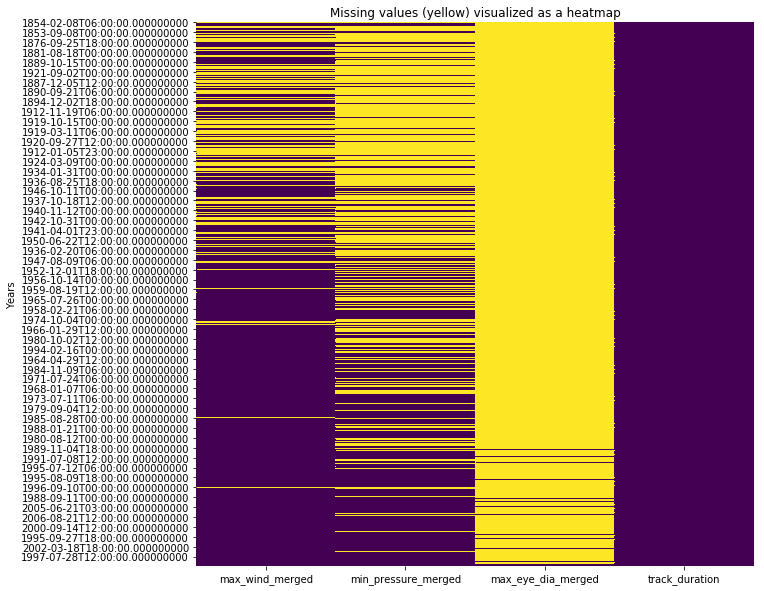

In [140]:
missing_data_viz = all_hurricanes_df.replace(0,np.NaN)
missing_data_viz = missing_data_viz.replace(-9999.0,np.NaN)
missing_data_viz['min_pressure_merged'] = missing_data_viz['min_pressure_merged'].replace(100.0,np.NaN)

plt.figure(figsize=(10,10))
missing_data_ax = sns.heatmap(missing_data_viz[['max_wind_merged', 'min_pressure_merged',
                                                'max_eye_dia_merged', 'track_duration']].isnull(),
                              cbar=False, cmap='viridis')
missing_data_ax.set_ylabel('Years')
missing_data_ax.set_title('Missing values (yellow) visualized as a heatmap')

All three observation columns - wind speed, atmospheric pressure and eye diameter, suffer from missing values. In general as technology improved over time, we were able to collect better data with fewer missing observations. In the sections below we attempt to fill these values using different techniques. We will compare how they fare and pick one of them for rest of the analysis.

### Missing value imputation

**Technique 1: Drop missing values**:
An easy way to deal with missing values is to drop those record from analysis. If we were to do that, we lose over a third of the hurricanes.

In [141]:
hurricanes_nona = missing_data_viz.dropna(subset=['max_wind_merged','min_pressure_merged'])
hurricanes_nona.shape

(5857, 19)

**Technique 2: Fill using median value**:
A common technique is to fill using median value (or a different measure of centrality). This technique computes the median of the entire column and applies that to all the missing values.

In [142]:
fill_values = {'max_wind_merged': missing_data_viz['max_wind_merged'].median(),
                'min_pressure_merged': missing_data_viz['min_pressure_merged'].median(),
              'track_duration_hrs': missing_data_viz['track_duration_hrs'].median()}
hurricanes_fillna = missing_data_viz.fillna(value=fill_values)

**Technique 3: Fill by interpolating between existing values**: A sophisticated approach is to interploate a missing value based on two of its closest observations.

In [143]:
hurricanes_ipl = missing_data_viz
hurricanes_ipl['max_wind_merged'] = hurricanes_ipl['max_wind_merged'].interpolate()
hurricanes_ipl['min_pressure_merged'] = hurricanes_ipl['min_pressure_merged'].interpolate()
hurricanes_ipl['track_duration_hrs'] = hurricanes_ipl['track_duration_hrs'].interpolate()

**Visualize all 3 techniques**

To compare how each of these techniques fared, we will plot the histogram of **wind speed** column after managing for missing values.

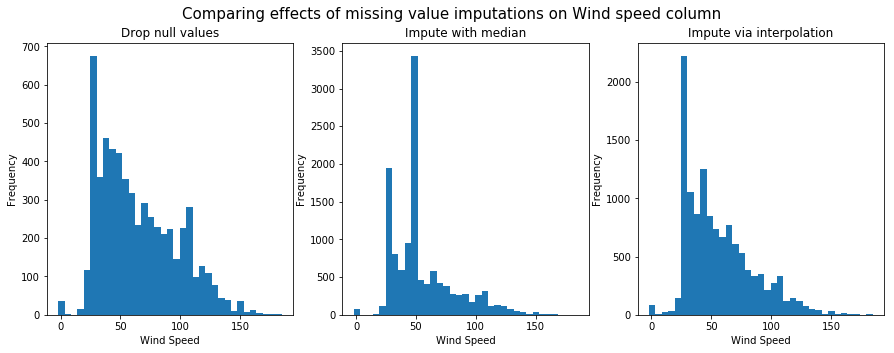

In [144]:
fig, ax = plt.subplots(1,3, sharex=True, figsize=(15,5))
fig.suptitle('Comparing effects of missing value imputations on Wind speed column', 
             fontsize=15)

hurricanes_nona['max_wind_merged'].plot(kind='hist', ax=ax[0], bins=35, title='Drop null values')
hurricanes_fillna['max_wind_merged'].plot(kind='hist', ax=ax[1], bins=35, title='Impute with median')
hurricanes_ipl['max_wind_merged'].plot(kind='hist', ax=ax[2], bins=35, title='Impute via interpolation')
for a in ax:
    a.set_xlabel('Wind Speed')

Next, we will plot the histogram of **atmospheric pressure** column after managing for missing values.

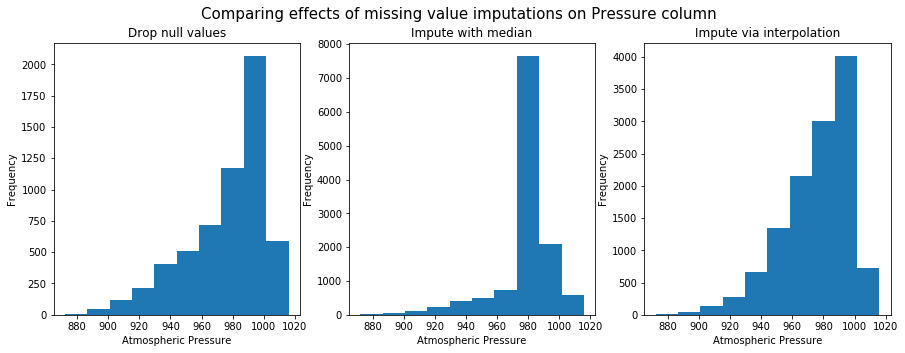

In [145]:
fig, ax = plt.subplots(1,3, sharex=True, figsize=(15,5))
fig.suptitle('Comparing effects of missing value imputations on Pressure column', 
             fontsize=15)

hurricanes_nona['min_pressure_merged'].plot(kind='hist', ax=ax[0], title='Drop null values')
hurricanes_fillna['min_pressure_merged'].plot(kind='hist', ax=ax[1], title='Impute with median')
hurricanes_ipl['min_pressure_merged'].plot(kind='hist', ax=ax[2], title='Impute via interpolation')
for a in ax:
    a.set_xlabel('Atmospheric Pressure')

Fill using **interpolation preserves shape** of the original distribution. So it will be used for further anlaysis.

# Does intensity of hurricanes increase over time?
This last part of this study analyzes if there a temporal trend in the intensity of hurricanes. A number of studies have concluded that anthropogenic influences in the form of global climate change make hurricanes worse and dangerous. We analyze if such patterns can be noticed from an empirical standpoint.

## Does the number of hurricanes increase over time?

Text(0.5,1,'Number of hurricanes per season')

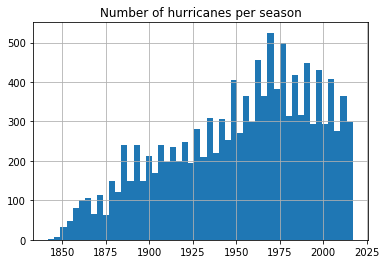

In [363]:
ax = all_hurricanes_df['min_season'].hist(bins=50)
ax.set_title('Number of hurricanes per season')

From the previous notebook, we noticed the number of hurricanes recorded has been steadily increasing, partly due to advancements in technology. We notice a reduction in number of hurricanes after 1970s. Let us split this up by basin and observe the the trend is similar.

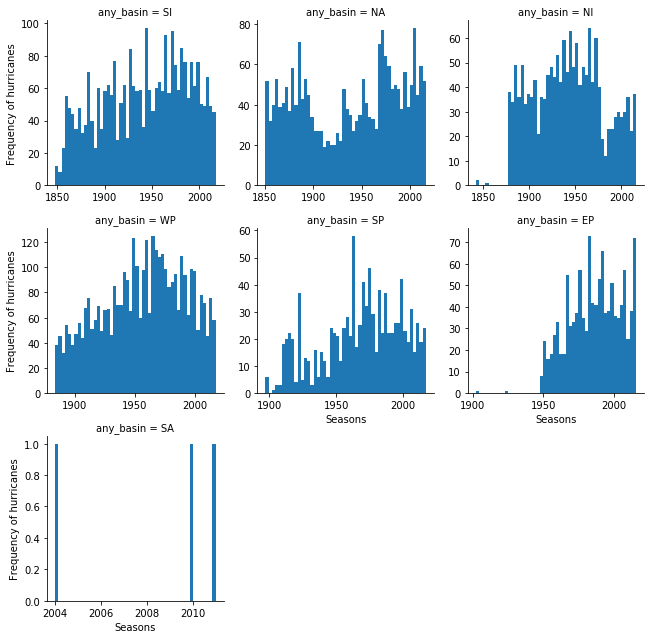

In [378]:
fgrid = sns.FacetGrid(data=all_hurricanes_df, col='any_basin', col_wrap=3,
                     sharex=False, sharey=False)
fgrid.map(plt.hist, 'min_season', bins=50)
fgrid.set_axis_labels(x_var='Seasons', y_var='Frequency of hurricanes')

Plotting the frequency of hurricanes by basin shows a similar trend with the number of hurricanes reducing globally after 1970s. [This is consistent with certain studies (1)](https://link.springer.com/epdf/10.1007/s00382-013-1713-0?shared_access_token=cHh_-kXbFWgMacxvFkMyWPe4RwlQNchNByi7wbcMAY65lj3v5VSTqd8rbUj9HyyFUZS9H0Z0WdJn6EgG-Onhfk9U48b6jvTjrJTuMH8OuGbT6R1Y54MGaHwYq2EEp6ppcoACaJgdWo3v3VtPDcq9Whm0MUw98Z4wCFy7jbwwcY4%3D). However this is only one part of the story. Below, we continue to analyze if the nature of hurricanes itself is changing, while the total number may reduce.

## Does hurricane wind speed increase over time?
To understand if wind speed increases over time, we create a scatter plot of `min_season` against the `max_wind_merged` column. The `seaborn` plotting library can enhance this plot with **correlation coefficient** and its level of signifance (**p value**).

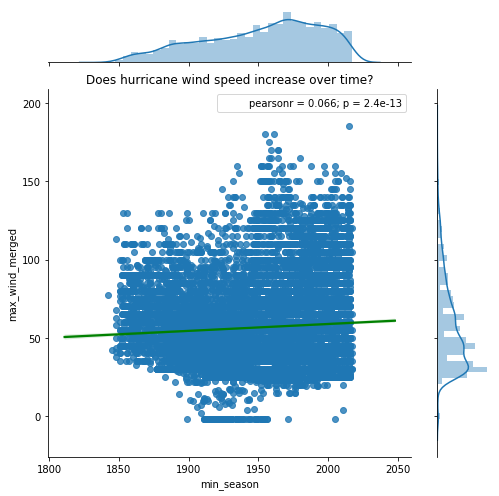

In [266]:
jgrid = sns.jointplot(x='min_season', y='max_wind_merged', data=hurricanes_ipl,
             kind='reg', joint_kws={'line_kws':{'color':'green'}}, height=7, space=0.5)
j = jgrid.annotate(stats.pearsonr)
j = jgrid.ax_joint.set_title('Does hurricane wind speed increase over time?')

From the plot above, we notice a small positive correlation. Wind speeds are observed to increase with time. The small `p-value` suggests this correlation (albeit small) is **statistically significant**. The plot above considers hurricanes across all the basins and regresses that against time. To get a finer picture, we need to **split the data by basins** and observe the correlation.

In [329]:
# since there are not many hurricanes observed over South Atlantic basin (SA), 
# we drop it from analysis
hurricanes_major_basins_df = hurricanes_ipl[hurricanes_ipl['any_basin'].isin(
                                            ['WP','SI','NA','EP','NI','SP'])]

Define a function that can compute `pearson-r` correlation coefficient for any two columns across all basins.

In [322]:
def correlate_by_basin(column_a, column_b, df=hurricanes_major_basins_df, 
                       category_column = 'any_basin'):
    # clean data by dropping any NaN values
    df_nona = df.dropna(subset=[column_a, column_b])
    
    # loop through the basins
    basins = list(df[category_column].unique())
    return_dict = {}
    for basin in basins:
        subset_df = df_nona[df_nona[category_column] == basin]
        r, p = stats.pearsonr(list(subset_df[column_a]), list(subset_df[column_b]))
        
        return_dict[basin] = [round(r,4), round(p,4)]
    
    # return correlation coefficient and p-value for each basin as a DataFrame
    return_df = pd.DataFrame(return_dict).T
    return_df.columns=['pearson-r','p-value']
    return return_df

### Analyzing hurricane wind speed over time by basin
Below we plot a grid of scatter plots with linear regression plots overlaid over them. The `seaborn` library's `lmplot()` function makes it trivial accomplish this in a single command.

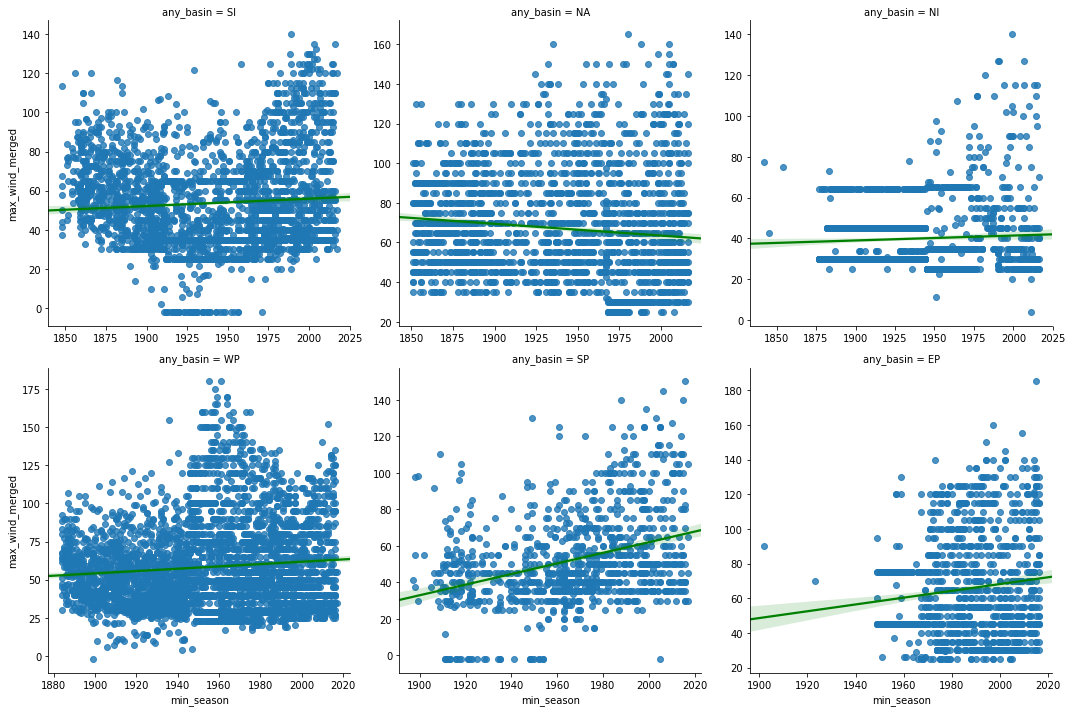

In [342]:
fgrid = sns.lmplot('min_season', 'max_wind_merged', col='any_basin', 
                   data=hurricanes_major_basins_df, col_wrap=3,
                   sharex=False, sharey=False, line_kws={'color':'green'})

From the scatter plots above, we notice the wind speeds in most basins show a slight positive trend, with **North Atlantic** being an exception. To explore this further, we compute the correlation coefficient and its p-value below.

In [328]:
wind_vs_season = correlate_by_basin('min_season','max_wind_merged')
print('Correlation coefficients for min_season vs max_wind_merged')
wind_vs_season

Correlation coefficients for min_season vs max_wind_merged


,pearson-r,p-value
SI,0.0686,0.0003
NA,-0.1073,0.0000
NI,0.0528,0.0357
WP,0.0891,0.0000
SP,0.3415,0.0000
EP,0.1177,0.0001


The table above displays the correlation coefficient of hurricane wind speed over time. Hurricanes over **Southern Pacific** basin exhibit a positive trend of increasing wind speeds. The `r` value over **North Atlantic** shows a weak negative trend. Since all the `p-value`s are less than `0.05`, these correlations are statistically significant.

### Analyzing hurricane category over time by basin
Hurricanes are classified on a [Saffir-Simpson](https://www.nhc.noaa.gov/aboutsshws.php) scale of `1-5` based on their wind speed. Let us compute this column on the dataset and observe if there are teomporal aspects to it.

In [414]:
def categorize_hurricanes(row, wind_speed_column='max_wind_merged'):
    wind_speed = row[wind_speed_column] * 1.152  # knots to mph
    if 74 <= wind_speed <= 95:
        return '1'
    elif 96 <= wind_speed <= 110:
        return '2'
    elif 111 <= wind_speed <= 129:
        return '3'
    elif 130 <= wind_speed <= 156:
        return '4'
    elif 157 <= wind_speed <= 500:
        return '5'

In [435]:
hurricanes_major_basins_df['category_str'] = hurricanes_major_basins_df.apply(categorize_hurricanes, 
                                                                              axis=1)
hurricanes_major_basins_df['category'] = pd.to_numeric(arg=hurricanes_major_basins_df['category_str'],
                                                      errors='coerce', downcast='integer')

hurricanes_major_basins_df.head(2)

,SHAPE,any_basin,any_name,any_sub_basin,count,end_datetime,max_eye_dia_merged,max_wind_merged,mean_latitude_merged,mean_longitude_merged,...,min_season,objectid,range_pressure_merged,range_wind_merged,start_datetime,track_duration,track_duration_hrs,track_duration_days,category,category_str
start_datetime,,,,,,,,,,,,,,,,,,,,,
1854-02-08 06:00:00,"{'paths': [[[59.60000000000002, -17.6000000000...",SI,NOT NAMED,MM,7.0,1854-02-10 18:00:00,NaN,NaN,-19.318571,60.639286,...,1854.0,1,NaN,NaN,1854-02-08 06:00:00,129600000.0,36.0,1.5,NaN,None
1859-08-24 12:00:00,"{'paths': [[[-23.5, 12.5], [-24.19999999999999...",NA,NOT NAMED,NA,9.0,1859-08-26 12:00:00,NaN,45.0,14.000000,-26.222222,...,1859.0,2,NaN,10.0,1859-08-24 12:00:00,172800000.0,48.0,2.0,NaN,None


We will create violin and bar plots to visualize the number of hurricane categories over different basins.

Text(0.5,1,'Number of hurricanes per category in each basin')

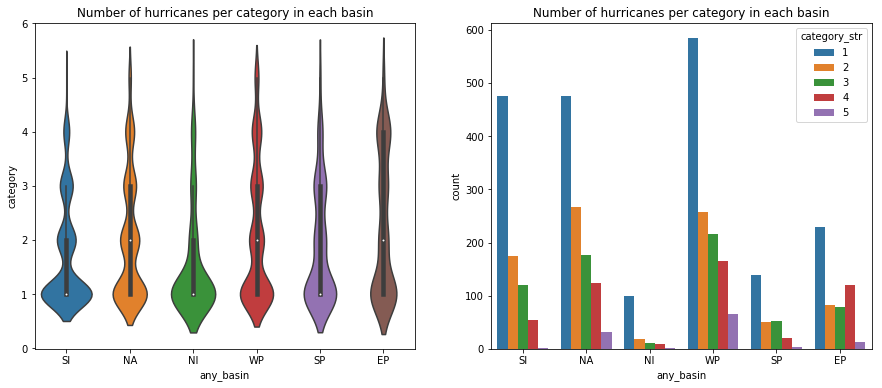

In [429]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
vplot = sns.violinplot(x='any_basin', y='category', data=hurricanes_major_basins_df, ax=ax[0])
vplot.set_title('Number of hurricanes per category in each basin')

cplot = sns.countplot(x='any_basin', hue='category_str', data=hurricanes_major_basins_df,
             hue_order=['1','2','3','4','5'], ax=ax[1])
cplot.set_title('Number of hurricanes per category in each basin')

We notice all basins are capable of generating major hurricanes (over 3). The **Eastern Pacific** basin appears to have a larger than the proportional number of major hurricanes. Below, we will regress the hurricane category against time to observe if there is a positive trend.

Text(0.5,1,'Scatter plot of hurricane categories over seasons')

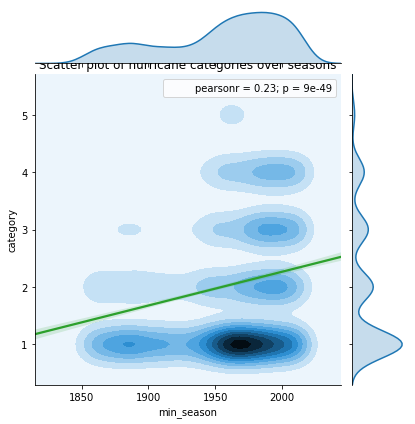

In [440]:
kde_regplot = sns.jointplot(x='min_season', y='category', 
                            data=hurricanes_major_basins_df, kind='kde', 
                            stat_func=stats.pearsonr).plot_joint(sns.regplot, 
                                                                 scatter=False)
kde_regplot.ax_joint.set_title('Scatter plot of hurricane categories over seasons')

Even at a global level, we notice a strong positive correlation between hurricane category and seasons. Below, we will split this across basins to observe if the trend holds good.

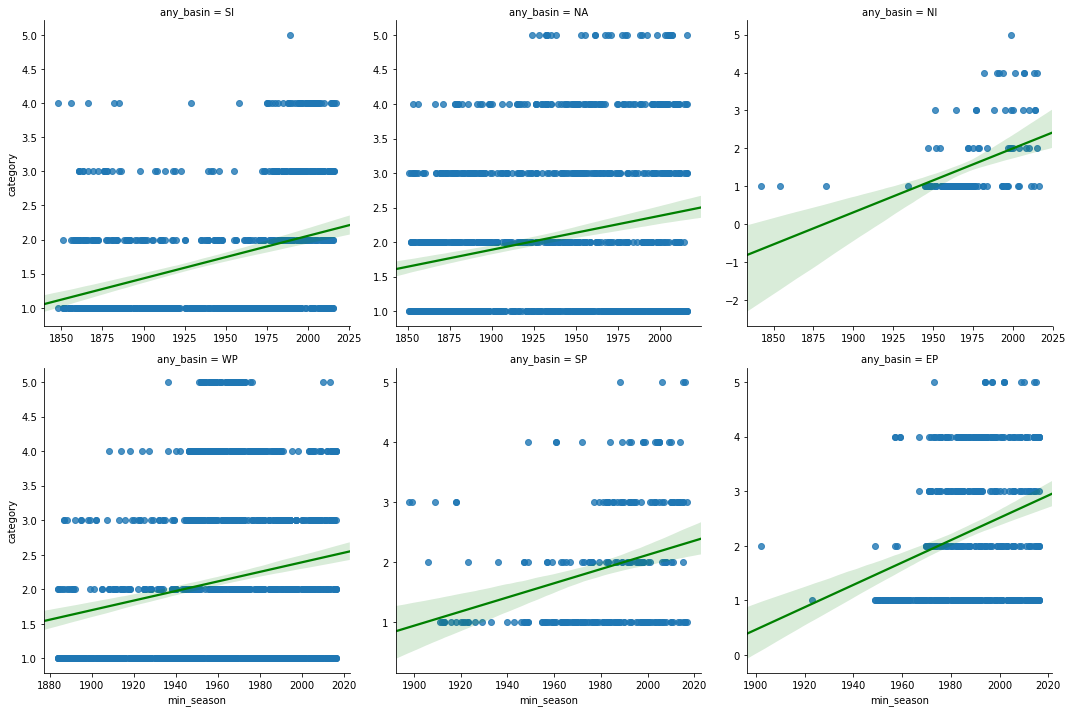

In [419]:
wgrid = sns.lmplot('min_season', 'category', col='any_basin', 
                   data=hurricanes_major_basins_df, col_wrap=3,
                   sharex=False, sharey=False, line_kws={'color':'green'})

In [442]:
category_corr_df = correlate_by_basin('min_season','category', df=hurricanes_major_basins_df)
print('Correlation coefficients for min_season vs hurricane category')
category_corr_df

Correlation coefficients for min_season vs hurricane category


,pearson-r,p-value
SI,0.3314,0.0
NA,0.2161,0.0
NI,0.4612,0.0
WP,0.1849,0.0
SP,0.2908,0.0
EP,0.2919,0.0


Thus, at both global and basin scales, we notice a **positive trend in the number of hurricanes of category `4` and higher**, while there is a general reduction in the quantity of hurricanes per season. This is along the lines of several studies [[1]](https://doi.org/10.1007/s00382-013-1713-0) [[2]](https://bankunderground.co.uk/2018/05/22/us-hurricane-clustering-a-new-reality/) [[3]](https://www.nature.com/articles/nature03906) [[4]](https://www.nytimes.com/2018/10/10/climate/hurricane-michael-climate-change.html). Thus while the total number of hurricanes per season may reduce, we notice an increase in the intensity of them.

## Does eye pressure decrease over time?
Just like a high wind speed, lower atmospheric pressure increases the intensity of hurricanes. To analyze this, we produce a scatter grid of `min_pressure_merged` column and regress it against `min_season` column. We split this by basins.

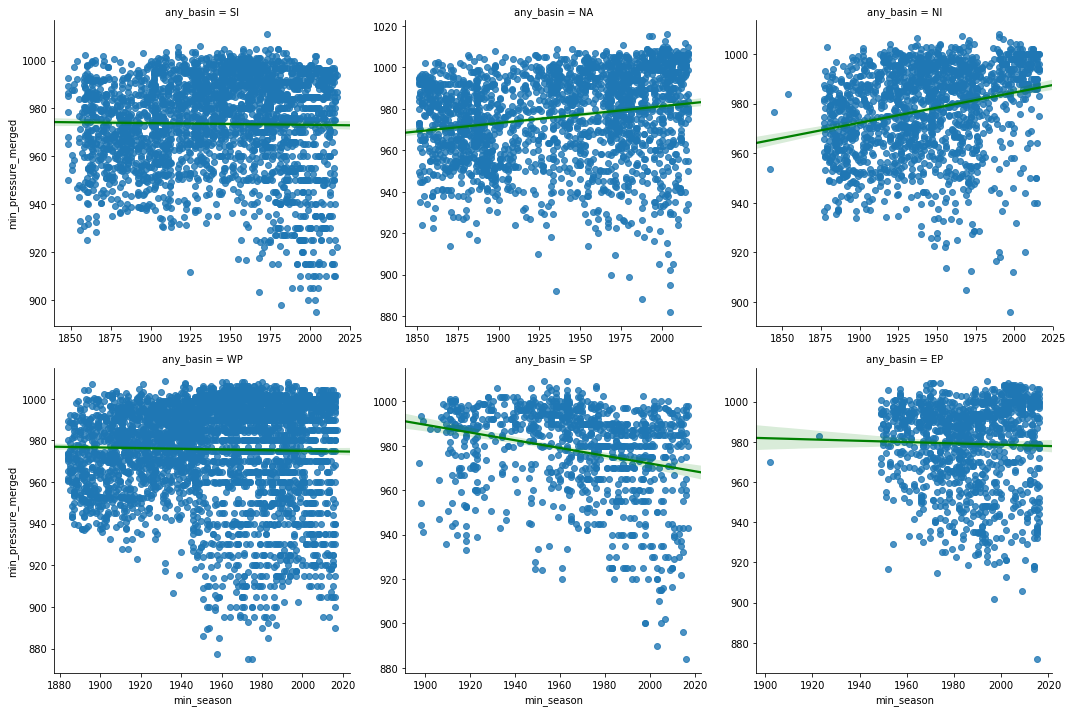

In [330]:
pgrid = sns.lmplot('min_season', 'min_pressure_merged', col='any_basin', 
                   data=hurricanes_major_basins_df, col_wrap=3,
                   sharex=False, sharey=False, line_kws={'color':'green'})

In [333]:
pressure_corr_df = correlate_by_basin('min_season','min_pressure_merged')
print('Correlation coefficients for min_season vs min_pressure_merged')
pressure_corr_df

Correlation coefficients for min_season vs min_pressure_merged


,pearson-r,p-value
SI,-0.0160,0.4027
NA,0.1911,0.0000
NI,0.2551,0.0000
WP,-0.0230,0.1606
SP,-0.2456,0.0000
EP,-0.0270,0.3612


Lower the atmospheric pressure, more intense is the hurricane. Hence we are looking for strong negative correlation between the pressure and season columns. From the charts and table above, we notice **South Pacific** basin once again tops the list with a mild negative correlation over time. The `p-value`s of **Western Pacific** and **Eastern Pacific** is larger than `0.05`, so we disregard their correlation coefficients. Over **North American** and **Indian** basins, we notice a weak positive correlation.

## Do hurricanes linger longer over time?
While wind speed and atmospheric pressure measure two types of intensities, a neverending hurricane can also hurt the communities affected as it inundates the coast with rainfall and storm surge for longer periods of time. In this section we correlate the track duration in days against seasons.

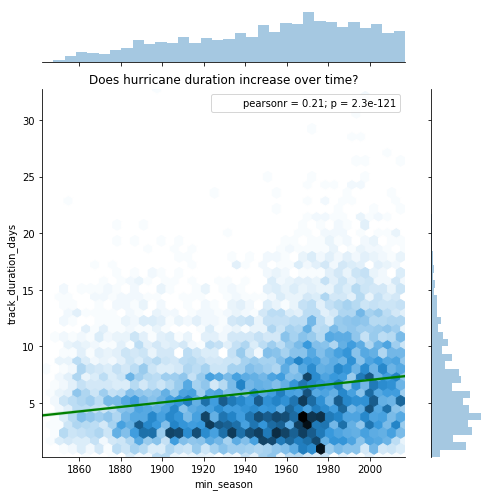

In [159]:
jgrid = sns.jointplot(x='min_season', y='track_duration_days', data=hurricanes_ipl,
             kind='hex', height=7, space=0.5)
j = jgrid.annotate(stats.pearsonr)

sns.regplot(x='min_season', y='track_duration_days', data=hurricanes_ipl, 
            ax=jgrid.ax_joint, color='green',scatter=False)

j = jgrid.ax_joint.set_title('Does hurricane duration increase over time?')

At a global scale, we notice an increase in the duration of hurricanes. Below we split this up by basins to get a finer look.

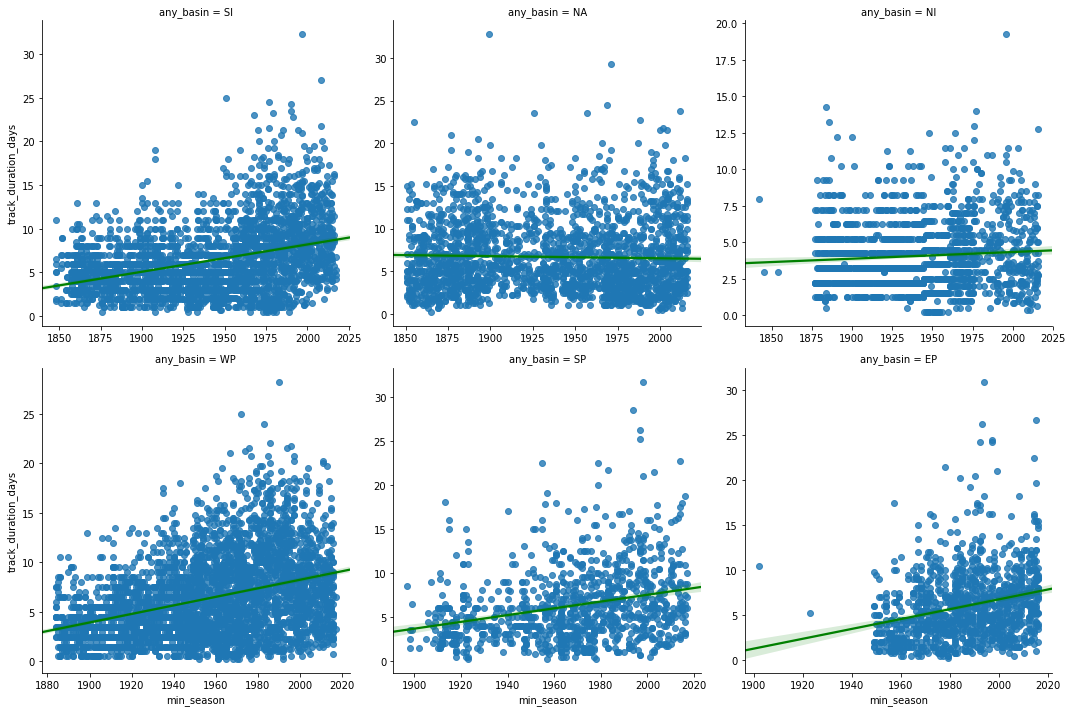

In [332]:
lgrid = sns.lmplot('min_season', 'track_duration_days', col='any_basin', 
                   data=hurricanes_major_basins_df, col_wrap=3,
                   sharex=False, sharey=False, line_kws={'color':'green'})

In [334]:
linger_time_corr_df = correlate_by_basin('min_season','track_duration_days')
print('Correlation coefficients for min_season vs track_duration_days')
linger_time_corr_df

Correlation coefficients for min_season vs track_duration_days


,pearson-r,p-value
SI,0.3577,0.0000
NA,-0.0295,0.1738
NI,0.0736,0.0034
WP,0.3627,0.0000
SP,0.2716,0.0000
EP,0.2560,0.0000


At most basins, we notice a positive trend in hurricane track duration. An exception to this is the **North Atlantic** basin where the `p-value` is not significant enough to let us draw any conclusion.

The trend we notice here could be partly due to technological advancements that allow us to identify and track hurricanes at a very early stage. Hence, to complement this, we will analyze if hurricanes travel longer than usual once the make a landfall.

## Do hurricanes travel longer inland over time?
Along the lines of track duration, it is relevant for us to investigate whether hurricanes travel longer inland over time. Thus, we correlate track length column of hurricanes that made landfall against seasons.

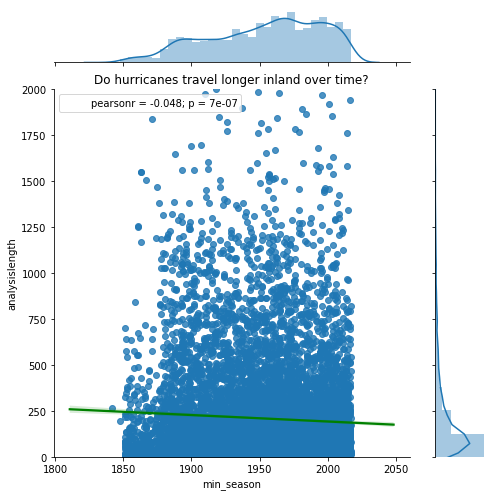

In [341]:
jgrid = sns.jointplot(x='min_season', y='analysislength', data=landfall_tracks_df,
                      kind='reg', joint_kws={'line_kws':{'color':'green'}}, 
                      height=7, space=0.5, ylim=[0,2000])
j = jgrid.annotate(stats.pearsonr)
j = jgrid.ax_joint.set_title('Do hurricanes travel longer inland over time?')

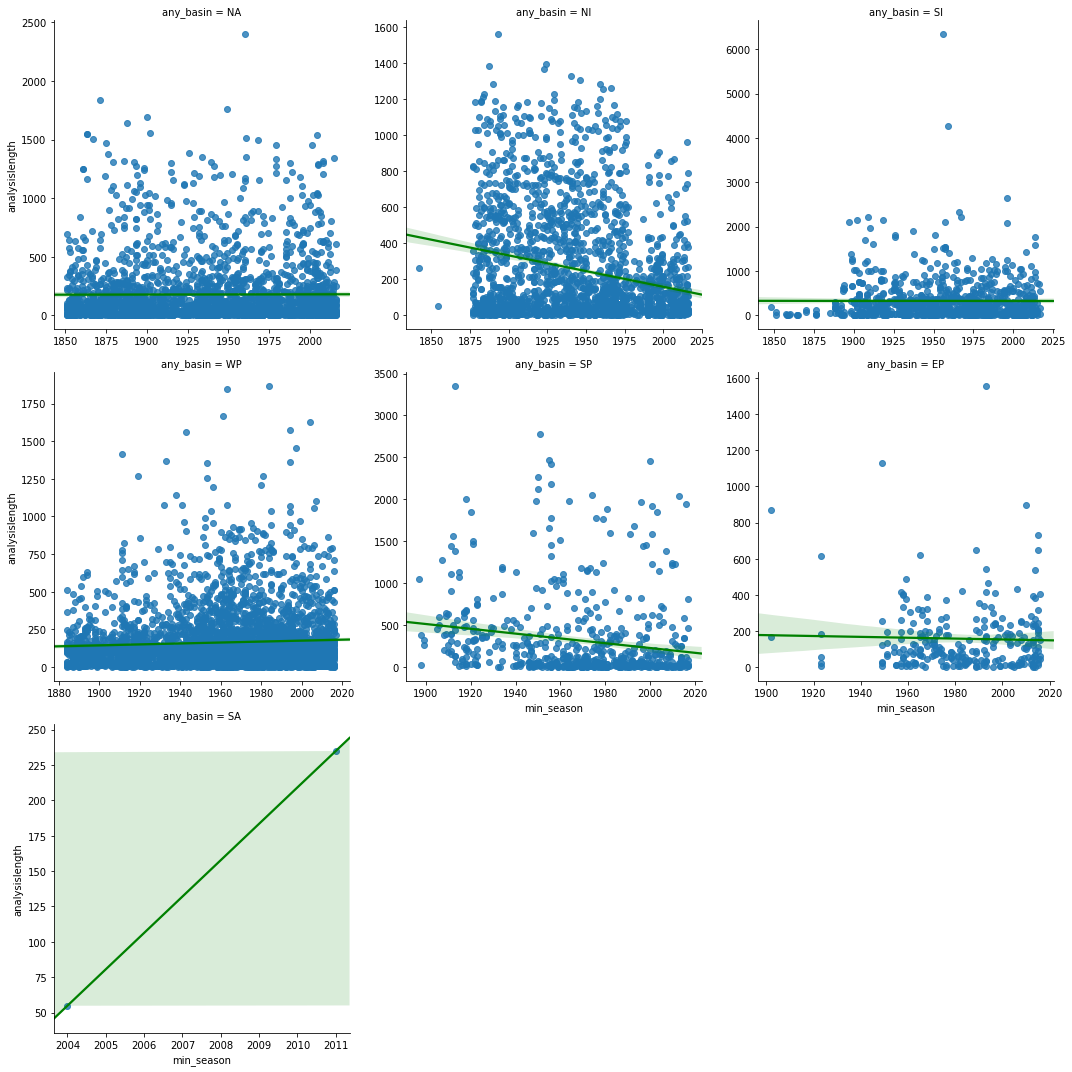

In [343]:
lgrid = sns.lmplot('min_season', 'analysislength', col='any_basin', 
                   data=landfall_tracks_df, col_wrap=3,
                   sharex=False, sharey=False, line_kws={'color':'green'})

In [344]:
linger_distance_corr_df = correlate_by_basin('min_season','analysislength', df=landfall_tracks_df)
print('Correlation coefficients for min_season vs inland track length')
linger_distance_corr_df

Correlation coefficients for min_season vs inland track length


,pearson-r,p-value
NA,0.0035,0.8611
NI,-0.2320,0.0000
SI,-0.0013,0.9684
WP,0.0555,0.0004
SP,-0.1722,0.0000
EP,-0.0296,0.6344
SA,1.0000,0.0000


When we correlated inland track length over time, we were able to unravel and interesting observation. At basins where there correlation is statistically significant, it is negative (**North Indian, Western Pacific, South Pacific**). Thus while the duration of hurricanes continues to increase (due to reasons discussed previously), we notice hurricanes travel shorter distances inland. This could be problematic of communities affected as the hurricane could remain stagnant and produce stronger than usual storm surges and precipitation.

## Correlate observations over time
Let us collect all trend analysis we performed so far into a single `DataFrame`.

In [443]:
# clean data by dropping any NaN values
subset_cols = ['min_season', 'max_wind_merged',
                'min_pressure_merged', 'track_duration_days', 'category']

df_nona = hurricanes_major_basins_df.dropna(subset=subset_cols)

# loop through the basins
basins = list(df_nona['any_basin'].unique())
return_dict = {}
for basin in basins:
    subset_df =df_nona[df_nona['any_basin'] == basin]
    row_vector = []
    for col in subset_cols[1:]:
        r, p = stats.pearsonr(list(subset_df['min_season']), list(subset_df[col]))
        if p < 0.05:
            row_vector.append(round(r,4))
        else:
            row_vector.append(pd.np.NaN)

    return_dict[basin] = row_vector

# return as a DataFrame
return_df = pd.DataFrame.from_dict(return_dict, orient='index', columns=subset_cols[1:])
return_df

,max_wind_merged,min_pressure_merged,track_duration_days,category
NA,0.2171,-0.0904,0.1633,0.2161
SI,0.3156,-0.3608,0.5433,0.3314
NI,0.4456,-0.2234,0.3414,0.4612
WP,0.1755,-0.3666,0.5860,0.1849
SP,0.3028,-0.3508,0.3819,0.2908
EP,0.2820,-0.3510,0.3077,0.2919


We can visualize this correlation table as a heat map to appreciate how the hurricane severity indicators correlate over seasons for each basin.

Text(0.5,1,'Heatmap of correlation coefficients of hurricane severity indicators')

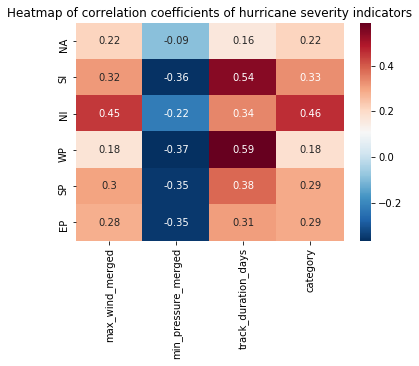

In [450]:
hm_plot = sns.heatmap(return_df, annot=True, linecolor='black', cmap='RdBu_r')
hm_plot.set_title('Heatmap of correlation coefficients of hurricane severity indicators')

## Conclusion
In this notebook used the aggregated hurricane tracks produced in part 1 and the landfall tracks layer produced in part 2. We checked for missing sensor observations and imputed those records via interpolation. We then comprehensively analyzed how hurricane severity indicators such as **wind speed**, **atmospheric pressure**, **track duration**, **track length inland** and **category** correlate over time (seasons). We noticed the total number of hurricanes have decreased since `1970`s globally and across all basins. While the number of hurricanes is less, we noticed their wind speed, track duration and category **correlate positively** and atmospheric pressure **correlates negatively** against seasons. This aligns with findings from major studies. Thus, we notice a reduction in the number of category 1 and 2 and an increase in the number of more severe, category 4, 5 hurricanes. We noticed the **North Indian** basin to be highly correlated in this regard.

In this study, through these 3 part notebooks, we saw how to download hurricane data for the past `169` years from NOAA NEIC site over FTP and how to it initially using Pandas. Since this data is larger than memory for average computers, we learnt how to aggregate the columns using the DASK distributed, delayed processing library. We input the result of DASK to the ArcGIS GeoAnalytics server to aggregate these point observations into hurricane tracks. The "reconstruct tracks" tool which performed this aggregation identified `12,362` individual hurricanes across the globe.

In the second notebook, we performed comprehensive visualization and exploratory analysis to understand the geography of hurricanes and the various basins they are categorized into. We observed a strong sinusoidal nature where hurricanes in the northern and southern hemisphere are offset by `6` months. We noticed certain names (`Irma`, `Florence`) are more popular than the rest. We overlaid the tracks over land boundary dataset to compute tracks traveled inland and identify places where landfall occur. Through density analysis of the landfall locations, we were able to identify the places there were most affected from a repeat landfall basis. By geo-enriching these places, we learnt that **China**, **Hongkong** and **India** are home to population that is most affected.

Many studies and articles [[5]](https://www.theguardian.com/environment/2018/oct/08/global-warming-must-not-exceed-15c-warns-landmark-un-report) [[6]](https://www.vox.com/2018/10/9/17951924/climate-change-global-warming-un-ipcc-report-takeaways) [[7]](https://www.vox.com/energy-and-environment/2018/10/3/17925470/hurricane-florence-2018-devastation-climate-change-flood-sea-level-rise) [[8]](https://fivethirtyeight.com/features/how-climate-change-made-our-hurricane-predictions-way-more-accurate/) shine light on anthropogenic influences on global Sea Surface Temperature (SST). Higher sea surface temperatures are observed to produce more intense storms; they are attributed to polar ice cap melting and rising sea levels. These combined with increased hurricane intensity can lead to severe strom surges causing increased flooding and damage of the coastal communities. Based on our density and geoenrichment analysis, we noticed these are places along the coast that are densely populated.

This study showcases how a comprehensive spatial data science project can be performed using ArcGIS and open source Python libraries on the ArcGIS Notebook server. The notebook medium makes it convenient to document code, narrative and graphics in one place. This helps in making research reproducible and approachable. Thus in this study we were able to empirically validate the conclusions derived by other studies. In future, when more hurricane datasets become available, this study can be repeated just by rerunning these notebooks.

#### References
 - [1. Recent intense hurricane response to global climate change. Holland, G. & Bruyère, C.L. Clim Dyn (2014) 42: 617.](https://doi.org/10.1007/s00382-013-1713-0)
 - [2. US Hurricane Clustering: A New Reality?](https://bankunderground.co.uk/2018/05/22/us-hurricane-clustering-a-new-reality/)
 - [3. Increasing destructiveness of tropical cyclones over the past 30 years](https://www.nature.com/articles/nature03906)
 - [4. The Hurricanes, and Climate-Change Questions, Keep Coming. Yes, They’re Linked. ](https://www.nytimes.com/2018/10/10/climate/hurricane-michael-climate-change.html)
 - [5. We have 12 years to limit climate change catastrophe, warns UN ](https://www.theguardian.com/environment/2018/oct/08/global-warming-must-not-exceed-15c-warns-landmark-un-report)
 - [6. Four big takeaways from the UN’s alarming climate change report](https://www.vox.com/2018/10/9/17951924/climate-change-global-warming-un-ipcc-report-takeaways)
 - [7. Hurricane Florence caused up to 22 billion in damages. Climate change made the storm worse.](https://www.vox.com/energy-and-environment/2018/10/3/17925470/hurricane-florence-2018-devastation-climate-change-flood-sea-level-rise)
 - [8. What Climate Change Taught Us About Hurricanes ](https://fivethirtyeight.com/features/how-climate-change-made-our-hurricane-predictions-way-more-accurate/)